> And the whole question of reinforcement learning is how can we get this ultimate reward that we will get and propagate it back and learned how to behave.                            
--MITx_6.86x

# 前言

## 强化学习基础篇

### 1. 初探强化学习

### 2. 多臂老虎机

#### 2.2. 问题介绍

实现一个拉杆数为 10 的多臂老虎机。其中拉动每根拉杆的奖励服从伯努利分布（Bernoulli distribution），即每次拉下拉杆有的概率获得的奖励为 1，有的概率获得的奖励为 0。奖励为 1 代表获奖，奖励为 0 代表没有获奖。

In [ ]:
import matplotlib.pyplot as plt
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np


class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """

    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）
        if np.random.rand() < self.probs[k]:  ## 依概率self.probs[k]返回的奖励1
            return 1
        else:
            return 0  ## 依概率1 - self.probs[k]返回的奖励0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

# 随机生成了一个10臂伯努利老虎机
# 获奖概率最大的拉杆为1号,其获奖概率为0.7203

用一个 Solver 基础类来实现上述的多臂老虎机的求解方案。

In [ ]:
class Solver:
    """ 多臂老虎机算法基本框架 """

    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        '''
        更新累积懊悔和计数
        '''
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()  ## 根据策略选择拉杆，然后拉动拉杆，算拉杆奖励的期望值
            self.counts[k] += 1  ## 拉动拉杆的次数+1
            self.actions.append(k)  ## 记录每一步的动作action，也就是拉动的拉杆标号
            self.update_regret(k)  ## 更新懊悔地累加值

#### 2.3. Exploration and Exploitation

##### 2.3.1. Epsilon-Greedy

每次以概率 $\epsilon$ 选择随机动作，以概率 $1-\epsilon$ 选择当前最优动作。

estimates增量更新推导：
$$
Q_{n+1} = \frac{1}{n+1} \sum_{i=1}^{n+1} r_{i}
$$
$$
      = \frac{1}{n+1} (r_{n+1} + \sum_{i=1}^{n} r_{i})
$$
$$
        = \frac{1}{n+1} (r_{n+1} + (n) \frac{1}{n} \sum_{i=1}^{n} r_{i})
$$
$$
        = \frac{1}{n+1} (r_{n+1} + (n) Q_{n})
$$
$$
        = Q_{n} + \frac{1}{n+1} (r_{n+1} - Q_{n})
$$


In [ ]:
class EpsilonGreedy(Solver):
    """ 
    epsilon贪婪算法,继承Solver类 
    T随机，R随机
    """

    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super().__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆，在0到K之间，左闭右开
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 算第K根拉杆的期望奖励，增量更新的
        return k

直观地展示，可以把每一时间步的累积函数绘制出来

In [ ]:
def plot_results(solvers, solver_names):
    """
    生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称
    """
    for idx, solver in enumerate(solvers):  ## 遍历所有的解决方案，实际上只有一个解决方案
        time_list = range(len(solver.regrets))  ## 每一步的懊悔记录，拿到横轴的数值
        plt.plot(time_list, solver.regrets, label=solver_names[idx])  # 绘制，横轴是时间步，纵轴是懊悔值
    plt.xlabel('Time steps')  ##  横轴的标签
    plt.ylabel('Cumulative regrets')  ##  纵轴的标签
    plt.title(f'{solvers[0].bandit.K}-armed bandit')  ##  标题
    plt.legend()  ##  图例
    plt.show()  ##  显示图片的


np.random.seed(1)  ## 初始化随机数的 seed 种子
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm)  ## 策略器初始化
epsilon_greedy_solver.run(5000)  ## 拉动拉杆共五千次，然后运算累加懊悔，每个杆的期望奖励等
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

# epsilon-贪婪算法的累积懊悔为：25.526630933945313

In [ ]:
# 绘制概率图
def plot_estimates(bandit, solver):
    x = range(bandit.K)
    plt.plot(x, solver.estimates, alpha=0.6, label='estimates')
    plt.plot(x, bandit.probs, alpha=0.6, label='real probs')
    plt.xlabel('Action')
    plt.ylabel('Value')
    plt.title('Estimates and real probabilities')
    plt.legend()
    for i in range(bandit.K):
        plt.text(i, bandit.probs[i], f'{bandit.probs[i]:.2f}', ha='center', va='bottom')
        plt.text(i, solver.estimates[i], f'{solver.estimates[i]:.2f}', ha='center', va='top')
    plt.show()
    
plot_estimates(bandit_10_arm, epsilon_greedy_solver)

尝试不同的参数 $\epsilon$，并比较不同参数下的累积懊悔值。

In [ ]:
np.random.seed(0)  ## 给定随机种子，保证实验可以复现
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]  ## 不同的ε值
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons  ## 初始化不同的策略解决方案
]
epsilon_greedy_solver_names = [f"epsilon={e}" for e in epsilons]  ## 不同ε值对应的名称
for solver in epsilon_greedy_solver_list:  ## 遍历策略解决方案，每个策略运行五千次
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)  ## 绘制图像的

尝试$\epsilon$值随时间反比例衰减的策略，即 $\epsilon = \frac{1}{t}$。

In [ ]:
class DecayingEpsilonGreedy(Solver):
    """ 
    epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 
    """

    def __init__(self, bandit, init_prob=1.0):
        super().__init__(bandit)  ## 初始化基类Solver
        self.estimates = np.array([init_prob] * self.bandit.K)  ## 初始化每根拉杆的期望奖励，=1
        self.total_count = 0  ## 拉杆的总次数

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        self.total_count += 1  ## 拉杆的次数+1，此时ε=拉杆次数的倒数，拉杆次数越多ε越小
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)  ## 此时有ε的概率随机选择拉杆
        else:
            k = np.argmax(self.estimates)  ## 此时有1-ε的概率选择期望奖励最大的拉杆

        r = self.bandit.step(k)  ## 获得第k根拉杆的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 增量更新期望奖励

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)  ## 初始化延迟策略解决方案
decaying_epsilon_greedy_solver.run(5000)  ## 运行五千次拉杆操作的
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])  ## 绘制图像的

In [ ]:
# 绘制概率图
plot_estimates(bandit_10_arm, decaying_epsilon_greedy_solver)

##### 2.3.2. Upper Confidence Bound (UCB)上置信界算法

霍夫丁不等式（Hoeffding's inequality）
$$
P(E(x) \geq \bar{x}_n + \epsilon) \leq e^{-2n\epsilon^2} = p
$$
$$
\ln p = -2n\epsilon^2
$$
$$
\epsilon = \sqrt{\frac{-\ln p}{2n}}
$$
即 $Q_t(a)$ 以$1-p$的概率 $< \hat{Q}_t(a) + \sqrt{\frac{-\ln p}{2n}}$。

令 $p = \frac{1}{t}$，则 $\epsilon = \sqrt{\frac{\ln t}{2n}}$。

为避免除数为0，为每根拉杆的尝试次数加上1，即 $\epsilon = \sqrt{\frac{\ln t}{2(n+1)}}$。

设定一个系数c来控制不确定性的比重，即 $Q_t(a) = \hat{Q}_t(a) + c\sqrt{\frac{\ln t}{2(n+1)}}$。

In [ ]:
class UCB(Solver):
    """ 
    UCB算法,继承Solver类 
    T选π，R随机
    """

    def __init__(self, bandit, coef, init_prob=1.0):  ##  初始化ucb类的
        super().__init__(bandit)  ##  初始化基类Solver
        self.total_count = 0  ##  总的拉杆次数
        self.estimates = np.array([init_prob] * self.bandit.K)  ## 初始化每根拉杆的期望奖励
        self.coef = coef  ## ucb的权重

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        self.total_count += 1  ##  运行的总次数+1

        ## 算出所有拉杆的期望奖励上界
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆(期望奖励上界最大的动作)
        r = self.bandit.step(k)  ## 拿到奖励的数值
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])  ## 增量更新对应拉杆的期望奖励
        return k


np.random.seed(1)  ## 给定随机数种子，方便复现的
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)  ## 实例化ucb类的
UCB_solver.run(5000)  ## 共拉杆五千次
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])  ## 绘制图像的

# 上置信界算法的累积懊悔为： 70.45281214197854

In [ ]:
# 绘制概率图
plot_estimates(bandit_10_arm, UCB_solver)

##### 2.3.3. Thompson Sampling

假设拉动每根拉杆的奖励服从一个特定的概率分布，然后根据拉动每根拉杆的期望奖励来进行选择。

通常用 Beta 分布对当前每个动作的奖励概率分布进行建模。具体来说，若某拉杆被选择了 $k$ 次，其中$m_1$次获奖，$m_0$次未获奖，则该拉杆的奖励概率服从参数为$(m_1+1, m_0+1)$的 Beta 分布。

In [ ]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """

    def __init__(self, bandit):
        super().__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        '''
        根据策略选择动作、根据动作获取奖励和更新期望奖励估值
        '''
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k
    
    def run(self, num_steps):
        '''
        更新累积懊悔和计数
        '''
        super().run(num_steps)
        # 完成后使用Beta分布的期望值来估计每根拉杆的获奖概率
        self.estimates = self._a / (self._a + self._b)


np.random.seed(1)  ## 给定随机数种子，方便复现的
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)  ## 实例化Thompson类的
thompson_sampling_solver.run(5000)  ## 共拉杆五千次
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

# 汤普森采样算法的累积懊悔为：57.19161964443925

In [ ]:
# 绘制概率图
plot_estimates(bandit_10_arm, thompson_sampling_solver)

### 3. 马尔可夫决策过程

> Markov decision processes are an extension of Markov chains; the difference is the addition of actions (allowing choice) and rewards (giving motivation). Conversely, if only one **a**ction exists for each state (e.g. “wait”) and all **r**ewards are the same (e.g. “zero”), a Markov decision process reduces to a Markov chain.”

#### 3.3. Utility Function

- why not finite horizon utility?

if you just go one step to go, you may go to extremely risky behaviour because you have no other chances.

- The main problem for MDPs is to optimize the agent’s behavior. To do so, **we first need to specify the criterion that we are trying to maximize in terms of accumulated rewards.**

$ U \leq \frac{R_{max}}{1-\lambda}  $

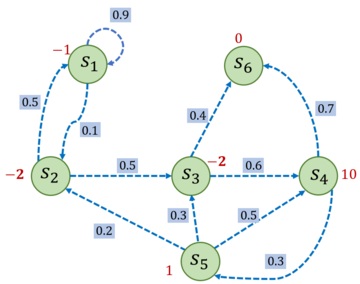

s1-s2-s3-s6

In [ ]:
import numpy as np
np.random.seed(0)
# 定义状态转移概率矩阵P
T = [
    [0.9, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.6, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0, 0.3, 0.7],
    [0.0, 0.2, 0.3, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
]
T = np.array(T)

rewards = [-1, -2, -2, 10, 1, 0]  # 定义奖励函数
gamma = 0.5  # 定义折扣因子


# 给定一条序列,计算从某个索引（起始状态）开始到序列最后（终止状态）得到的回报
from copy import deepcopy
def compute_return(start_index, chain, gamma):
    G = 0
    ret = []
    for i in reversed(range(start_index, len(chain))): ## 运算的方向要倒着来
        g_ = deepcopy(G)
        G = gamma * G + rewards[chain[i] - 1]       ## 从后往前依次运算求出结果
        ret.append([G, gamma, g_, rewards[chain[i] - 1], chain[i]]) ## 保存
    '''
    https://zhuanlan.zhihu.com/p/655615836
     0.0 = 0.5 *  0     +   0         6
    -2.0 = 0.5 *  0     +  -2         6->3
    -3.0 = 0.5 * -2.0   +  -2         3->2
    -2.5 = 0.5 * -3.0   +  -1         2->1
   ret=    [[ 0.0, 0.5,  0,    0, 6], 
            [-2.0, 0.5,  0.0, -2, 3], 
            [-3.0, 0.5, -2.0, -2, 2], 
            [-2.5, 0.5, -3.0, -1, 1]]
    '''
    return G


# 一个状态序列,s1-s2-s3-s6
chain = [1, 2, 3, 6]
start_index = 0
G = compute_return(start_index, chain, gamma)
print("根据本序列计算得到回报为：%s。" % G)

# 根据本序列计算得到回报为：-2.5。

#### 3.3.2. 使用Bellman equation的解析解

$ V = R + \gamma TV $

$ (I - \gamma T) V = R $

$ V = (I - \gamma T)^{-1} R $

In [ ]:
def compute(T, rewards, gamma, states_num):
    ''' 利用贝尔曼方程的矩阵形式计算解析解,states_num是MRP的状态数 '''
    rewards = np.array(rewards).reshape((-1, 1))  #将rewards写成列向量形式    ## r：每个状态的奖励值
## 对应求解析解的公式，V=(1-γP)^(-1)r
    # value = np.dot(np.linalg.inv(np.eye(states_num, states_num) - gamma * T), rewards)
    value = np.asmatrix(np.eye(states_num) - gamma * T).I @ rewards

    return value


V = compute(T, rewards, gamma, 6)
print("MRP中每个状态价值分别为\n", V)

# MRP中每个状态价值分别为
#  [[-2.01950168]
#  [-2.21451846]
#  [ 1.16142785]
#  [10.53809283]
#  [ 3.58728554]
#  [ 0.        ]]

#### 3.4. 马尔可夫决策过程（Markov decision process，MDP）

In [5]:
S = ["s1", "s2", "s3", "s4", "s5"]  # 状态集合
A = ["保持s1", "前往s1", "前往s2", "前往s3", "前往s4", "前往s5", "概率前往"]  # 动作集合
# 状态转移函数
T = {
    "s1-保持s1-s1": 1.0,
    "s1-前往s2-s2": 1.0,
    "s2-前往s1-s1": 1.0,
    "s2-前往s3-s3": 1.0,
    "s3-前往s4-s4": 1.0,
    "s3-前往s5-s5": 1.0,
    "s4-前往s5-s5": 1.0,
    "s4-概率前往-s2": 0.2,
    "s4-概率前往-s3": 0.4,
    "s4-概率前往-s4": 0.4,
}
# 奖励函数
R = {
    "s1-保持s1": -1,
    "s1-前往s2": 0,
    "s2-前往s1": -1,
    "s2-前往s3": -2,
    "s3-前往s4": -2,
    "s3-前往s5": 0,
    "s4-前往s5": 10,
    "s4-概率前往": 1,
}
gamma = 0.5  # 折扣因子
MDP = (S, A, T, R, gamma)

# 策略π1,随机策略
pi_1 = {
    "s1-保持s1": 0.5,
    "s1-前往s2": 0.5,
    "s2-前往s1": 0.5,
    "s2-前往s3": 0.5,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.5,
    "s4-概率前往": 0.5,
}
# 策略π2
pi_2 = {
    "s1-保持s1": 0.6,
    "s1-前往s2": 0.4,
    "s2-前往s1": 0.3,
    "s2-前往s3": 0.7,
    "s3-前往s4": 0.5,
    "s3-前往s5": 0.5,
    "s4-前往s5": 0.1,
    "s4-概率前往": 0.9,
}


# 把输入的两个字符串通过“-”连接,便于使用上述定义的P、R变量
def join(str1, str2):
    return str1 + '-' + str2

In [6]:
gamma = 0.5
# 转化后的MRP的状态转移矩阵
T_from_mdp_to_mrp = [
    [0.5, 0.5, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.5, 0.5],
    [0.0, 0.1, 0.2, 0.2, 0.5],
    [0.0, 0.0, 0.0, 0.0, 1.0],
]
'''
T(1|1) = pi_1["s1-保持s1"] * T["s1-保持s1-s1"] = 1 * 0.5 = 0.5
T(2|1) = pi_1["s1-前往s2"] * T["s1-前往s2-s2"] = 1 * 0.5 = 0.5
T(1|2) = pi_1["s2-前往s1"] * T["s2-前往s1-s1"] = 1 * 0.5 = 0.5
T(3|2) = pi_1["s2-前往s3"] * T["s2-前往s3-s3"] = 1 * 0.5 = 0.5
T(4|3) = pi_1["s3-前往s4"] * T["s3-前往s4-s4"] = 1 * 0.5 = 0.5
T(5|3) = pi_1["s3-前往s5"] * T["s3-前往s5-s5"] = 1 * 0.5 = 0.5
T(2|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s2"] = 0.5 * 0.2 = 0.1
T(3|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s3"] = 0.5 * 0.4 = 0.2
T(4|4) = pi_1["s4-概率前往"] * T["s4-概率前往-s4"] = 0.5 * 0.4 = 0.2
T(5|4) = pi_1["s4-前往s5"] * T["s4-前往s5-s5"] = 0.5 * 1 = 0.5
T(5|5) = 1
'''
T_from_mdp_to_mrp = np.array(T_from_mdp_to_mrp)
R_from_mdp_to_mrp = [-0.5, -1.5, -1.0, 5.5, 0]  ## MDP转MRP以后的状态奖励
'''
r(s1) = pi_1["s1-保持s1"] * R["s1-保持s1"] + pi_1["s1-前往s2"] * R["s1-前往s2"] = -1 * 0.5 + 0 * 0.5 = -0.5
r(s2) = pi_1["s2-前往s1"] * R["s2-前往s1"] + pi_1["s2-前往s3"] * R["s2-前往s3"] = -1 * 0.5 + -2 * 0.5 = -1.5
r(s3) = pi_1["s3-前往s4"] * R["s3-前往s4"] + pi_1["s3-前往s5"] * R["s3-前往s5"] = -2 * 0.5 + 0 * 0.5 = -1
r(s4) = pi_1["s4-前往s5"] * R["s4-前往s5"] + pi_1["s4-概率前往"] * R["s4-概率前往"] = 10 * 0.5 + 1 * 0.5 = 5.5
r(s5) = 0
也就求出了T_from_mdp_to_mrp 奖励函数的
'''

V = compute(T_from_mdp_to_mrp, R_from_mdp_to_mrp, gamma, 5)
print("MDP中每个状态价值分别为\n", V)

# MDP中每个状态价值分别为
#  [[-1.22555411]
#  [-1.67666232]
#  [ 0.51890482]
#  [ 6.0756193 ]
#  [ 0.        ]]

MDP中每个状态价值分别为
 [[-1.22555411]
 [-1.67666232]
 [ 0.51890482]
 [ 6.0756193 ]
 [ 0.        ]]
